In [327]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
import glob as gl

## Linear Regression For Human Observed Concat Data

In [328]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [329]:
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'r') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    print("Raw Training Generated..")
    return t

def GenerateRawData(filePath):    
    dataMatrix = [] 
    with open(filePath, 'r') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   

    dataMatrix = np.transpose(dataMatrix)     
    print ("Data Matrix Generated..")
    return dataMatrix

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    return BigSigma

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.pinv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    return W

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 60):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    print(str(TrainingPercent) + "% Training Data Generated..") #here
    return d2

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))


def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

# Data Generation

In [330]:
RawTarget = GetTargetVector('HD_Concat_target.csv')
RawData   = GenerateRawData('HD_Concat.csv')

Raw Training Generated..
Data Matrix Generated..


In [331]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)

# Validation Data

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))


# Testing Data

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))


80% Training Data Generated..


# Weight Calculation

In [332]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)



# Linear Regression Using Gradient Descent For Human Observed Concat Data

In [347]:
W_Now        = np.dot(220, W)
La           = 3
learningRate = 0.02
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,800):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [348]:
print ('----------Gradient Descent Solution--------------------')
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
E_rms Training   = 0.36823
E_rms Validation = 0.06079
E_rms Testing    = 0.06061


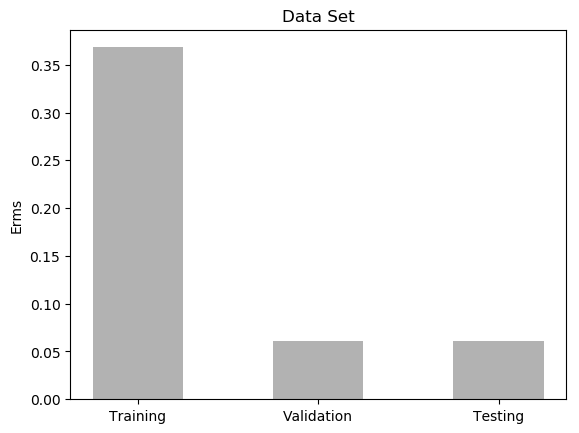

In [350]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
data_set = ('Training', 'Validation', 'Testing')
y_pos = np.arange(len(data_set))
accuracy = [float(np.around(min(L_Erms_TR),5)),float(np.around(min(L_Erms_Val),5)),float(np.around(min(L_Erms_Test),5))]
 
plt.bar(y_pos, accuracy, align='center', alpha=0.5, color=(0.4, 0.4, 0.4, 0.4), width=0.5)
plt.xticks(y_pos, data_set)
plt.ylabel('Erms')
plt.title('Data Set')
plt.show()

# Logistic Regression For Human Observed Concat Data

In [351]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=10000000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            loss = self.__loss(h, y)
                
            if(self.verbose ==True and i % 10000 == 0):
                print(loss)
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()



In [365]:
log_model = LogisticRegression(lr=0.00001, num_iter=100000)

log_model.fit(TrainingData.transpose(), TrainingTarget)

# Prediction for Validation Data 
prediction = log_model.predict(ValData.transpose())
hd_validate_concat = (prediction == ValData).mean()

# Prediction for Testing Data 
prediction = log_model.predict(TestData.transpose())
hd_test_concat = (prediction == TestData).mean()

print(hd_validate_concat)
print(hd_test_concat)

0.3129395218002813
0.32873319179051663


# Linear Regression For Human Observed Subtracted Data

# Data Generation

In [366]:
RawTarget = GetTargetVector('HD_Subtract_target.csv')
RawData   = GenerateRawData('HD_Subtract.csv')

Raw Training Generated..
Data Matrix Generated..


In [367]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)

# Validation Data

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))


# Testing Data

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))

80% Training Data Generated..


# Weight Calculation

In [368]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)



In [387]:
W_Now        = np.dot(220, W)
La           = 3
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,900):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [388]:
print ('----------Gradient Descent Solution--------------------')
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
E_rms Training   = 0.41421
E_rms Validation = 0.0
E_rms Testing    = 0.0


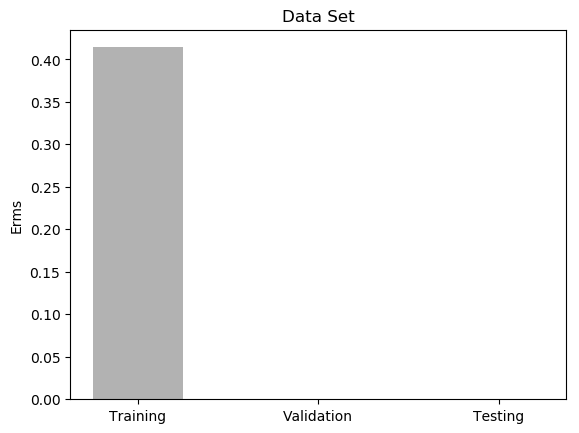

In [389]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
data_set = ('Training', 'Validation', 'Testing')
y_pos = np.arange(len(data_set))
accuracy = [float(np.around(min(L_Erms_TR),5)),float(np.around(min(L_Erms_Val),5)),float(np.around(min(L_Erms_Test),5))]
 
plt.bar(y_pos, accuracy, align='center', alpha=0.5, color=(0.4, 0.4, 0.4, 0.4), width=0.5)
plt.xticks(y_pos, data_set)
plt.ylabel('Erms')
plt.title('Data Set')
plt.show()

# Logistic Regression For Human Observed Subtracted Data

In [256]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            loss = self.__loss(h, y)
                
            if(self.verbose ==True and i % 10000 == 0):
                print(loss)
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()




In [399]:
log_model = LogisticRegression(lr=0.8, num_iter=100000)

log_model.fit(TrainingData.transpose(), TrainingTarget)

# Prediction for Validation Data 
prediction = log_model.predict(ValData.transpose())
hd_validate_subtract = (prediction == ValData).mean()

# Testing Data Prediction
prediction = log_model.predict(TestData.transpose())
hd_test_subtract = (prediction == TestData).mean()

print(hd_validate_subtract)
print(hd_test_subtract)

0.6659634317862166
0.5548478414720452


# Linear Regression For GSC Concat Data

In [400]:
RawTarget = GetTargetVector('gsc_Subtract_target.csv')
RawData   = GenerateRawData('gsc_Subtract.csv')

Raw Training Generated..
Data Matrix Generated..


In [401]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

# Validation Data

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

# Testing Data

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

80% Training Data Generated..
(2288,)
(512, 2288)
(285,)
(512, 285)
(285,)
(512, 285)


# Weight Calculation

In [402]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)




In [407]:
W_Now        = np.dot(220, W)
La           = 3
learningRate = 0.1
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,800):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [408]:
print ('----------Gradient Descent Solution--------------------')
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
E_rms Training   = 0.40636
E_rms Validation = 0.0788
E_rms Testing    = 0.07362


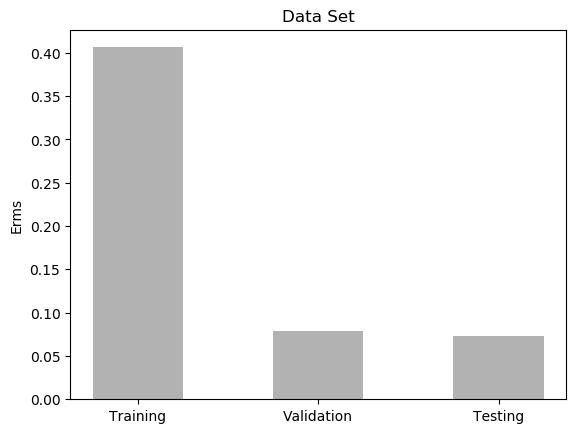

In [409]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
data_set = ('Training', 'Validation', 'Testing')
y_pos = np.arange(len(data_set))
accuracy = [float(np.around(min(L_Erms_TR),5)),float(np.around(min(L_Erms_Val),5)),float(np.around(min(L_Erms_Test),5))]
 
plt.bar(y_pos, accuracy, align='center', alpha=0.5, color=(0.4, 0.4, 0.4, 0.4), width=0.5)
plt.xticks(y_pos, data_set)
plt.ylabel('Erms')
plt.title('Data Set')
plt.show()

# Logistic Regression For GSC Concat Data

In [233]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            loss = self.__loss(h, y)
                
            if(self.verbose ==True and i % 10000 == 0):
                print(loss)
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()





In [415]:
log_model = LogisticRegression(lr=0.08, num_iter=100000)

log_model.fit(TrainingData.transpose(), TrainingTarget)

# Prediction for Validation Data
prediction = log_model.predict(ValData.transpose())
gsc_validate_concat = (prediction == ValData).mean()

# Prediction for Testing Data
prediction = log_model.predict(TestData.transpose())
gsc_test_concate = (prediction == TestData).mean()

print(gsc_validate_concat)
print(gsc_test_concate)

0.5028782894736842
0.28875411184210525


# Linear Regression For GSC Subtract Data

In [416]:
RawTarget = GetTargetVector('gsc_Subtract_target.csv')
RawData   = GenerateRawData('gsc_Subtract.csv')

Raw Training Generated..
Data Matrix Generated..


In [417]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

# Validation Data

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

# Testing Data

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

80% Training Data Generated..
(2288,)
(512, 2288)
(285,)
(512, 285)
(285,)
(512, 285)


# Weight Calculation

In [418]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)





In [446]:
W_Now        = np.dot(220, W)
La           = 3
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,810):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [447]:
print ('----------Gradient Descent Solution--------------------')
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
E_rms Training   = 0.49155
E_rms Validation = 0.15821
E_rms Testing    = 0.17945


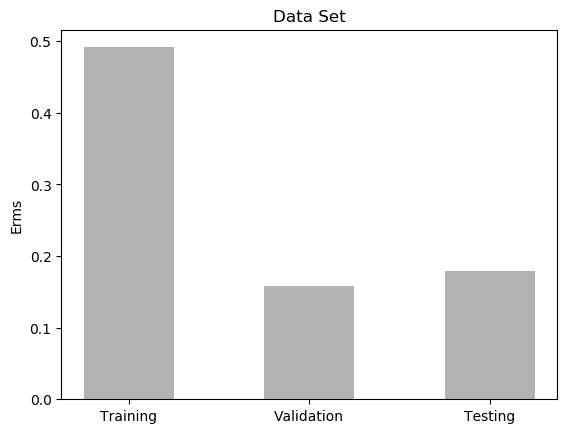

In [448]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
data_set = ('Training', 'Validation', 'Testing')
y_pos = np.arange(len(data_set))
accuracy = [float(np.around(min(L_Erms_TR),5)),float(np.around(min(L_Erms_Val),5)),float(np.around(min(L_Erms_Test),5))]
 
plt.bar(y_pos, accuracy, align='center', alpha=0.5, color=(0.4, 0.4, 0.4, 0.4), width=0.5)
plt.xticks(y_pos, data_set)
plt.ylabel('Erms')
plt.title('Data Set')
plt.show()

# Logistic Regression For GSC Subtract Data

In [449]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            loss = self.__loss(h, y)
                
            if(self.verbose ==True and i % 10000 == 0):
                print(loss)
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()






In [451]:
log_model = LogisticRegression(lr=0.06, num_iter=100000)

log_model.fit(TrainingData.transpose(), TrainingTarget)

# Prediction for Validation Data 
prediction = log_model.predict(ValData.transpose())
gsc_validate_subtract = (prediction == ValData).mean()

# Predictionn for Testing Data 
prediction = log_model.predict(TestData.transpose())
gsc_test_subtract = (prediction == TestData).mean()

print(p_concat_val)
print(p_concat_test)

0.45218002812939523
0.32554847841472045
